# Introduction to Bayesian Inference (2)

This part of the series is all about contrasting the frequentist approch to linear regression vs. the Bayesian approach to linear regression. It contains the theory as well as the practial implementation using probabilistic programming with PyMC3.  
<br>
You should be already familiar with the concepts of 
* Bayes' theorem & priors (see part 1 of Introduction to Bayesian Inference)
* probability distributions
* (simple) linear regression
* Maximum Likelihood Estimation

for this notebook.

### Contents
1. Linear Regression  
2. The Frequentist Approach  
    2.1 Linear Regression using sklearn  
3. The Bayesian Approach  
    3.1 Maximum-a-Posteriori Estimation  
    3.2 Bayesian Inference  
4. Probabilistic Programming  
    4.1 OLS Regression Model using PyMC3  
    4.2 Bayesian Linear Regression using PyMC3  

# 1. Linear Regression

For a dataset $\mathcal{D} = \{\mathbf X, \mathbf y\}$, where $\mathbf{\mathbf X} \in \mathbb{R}^{n \times k}$ is a feature matrix and $\mathbf y \in \mathbb{R}^{n}$ a vector containing the (true) target variables, the regression model can be described by

\begin{align} 
f(\mathbf X) = \mathbf{X}\mathbf w, \quad \mathbf y=f(\mathbf X) +\mathbf\epsilon ,
\end{align}

where the model's parameters $\mathbf w$ are called weights. The noise (error) term is *I.I.D.* and follows a normal distribution *(N.I.D)*, such that $\mathbf\epsilon \sim \mathcal{N}(\mathbf{0}, \sigma^2 \mathbf{I})$. Given this assumption and being aware of the relationship $\mathbf\epsilon = \hat{\mathbf y} - \mathbf y$, it becomes clear that, as a result the target variables $\mathbf y$ are assumed to be normal distributed with $\mathbf y \sim \mathcal{N}(\mathbf{X}\mathbf w, \sigma^2 \mathbf{I})$. From that, the likelihood function $\mathcal{L}$ can be represented as

\begin{align}
\mathcal{L}(\mathbf y|\mathbf{\mathbf X},\mathbf w) =  \prod\limits_{i=1}^n f(y_i|\mathbf{x_i}, \mathbf w) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp^{- \: \dfrac{(\mathbf y - \mathbf X \mathbf w)^2}{2\sigma^2}}.
\end{align}

# 2. The Frequentist Approach
For the frequentist approach, Maximum Likelihood Estimation (MLE) is utilized by applying the logarithmic function, such that the objective function is $\log \mathcal{L}$. The resulting first term $\log(\frac{1}{\sqrt{2\pi\sigma^2}})$ is not relevant for the optimization and can be ignored, hence, the maximum likelihood estimator $\hat{\mathbf w}_{MLE}$ is

\begin{align} 
\hat{\mathbf w}_{MLE} &= \operatorname*{arg~max}_w {- \: \dfrac{(\mathbf y - \mathbf X \mathbf w)^T (\mathbf y - \mathbf X \mathbf w)}{2\sigma^2}} \:.
\end{align} 

The term $2\sigma^2$ is just a constant and can be ignored. By flipping the negative sign, the optimization problem becomes

\begin{align} 
\hat{\mathbf w}_{MLE} &= \operatorname*{arg~min}_w \: (\mathbf y - \mathbf X \mathbf w)^T (\mathbf y - \mathbf X \mathbf w) \:.
\end{align} 

Given the definition of the ordinary least-squares (OLS) estimator $\hat{\mathbf w}_{OLS}$

\begin{align} 
\hat{\mathbf w}_{OLS} =  \operatorname*{arg~min}_w ||\mathbf{\epsilon}||_2 = \operatorname*{arg~min}_w ||\mathbf{y}-\mathbf{X}\mathbf w||_2 = \operatorname*{arg~min}_w \: (\mathbf y - \mathbf X \mathbf w)^T (\mathbf y - \mathbf X \mathbf w) \:,
\end{align} 

it can be seen that for the assumption of $\mathbf\epsilon \sim \mathcal{N}(\mathbf{0}, \sigma^2 \mathbf{I})$ the *MLE* and *OLS* estimators are equivalent.

### Create a Dataset
Too see how one can apply the different approaches to regression in python, let's create some synthetic data for an illustrative example.  
  
<u> **Scenario:** </u>  
*Imagine we are not aware that besides the Celsius scale also the Fahrenheit temperature scale exits. We have two thermometers, one for each scale, and start measuring temperatures with both, at the same time and place. Soon, we notice that there seems to be a relationship between both scales, which we would like to quantify. Unfortunately, the thermometers are of bad quality and generate noisy data.*  

Note: The true relationship is: $Fahrenheit^{\circ} = 32 + 1.8 Celsius^{\circ}$

To create some synthtetic data, the function `make_dataset` creates a 2d numpy array with the size of `n_samples`, containing observations for Celsius temperatures in the range of $[-20, 50]$ and their corresponding Fahrenheit values. To simulate noisy oberservations, some Gaussian noise, which can be controlled by the `noise_level` parameter, is added. The results can be replicated by setting the `seed` parameter to an integer value.  

Finally, the data is splitted 80/20 into train/test sets.

Correlation is: 0.85


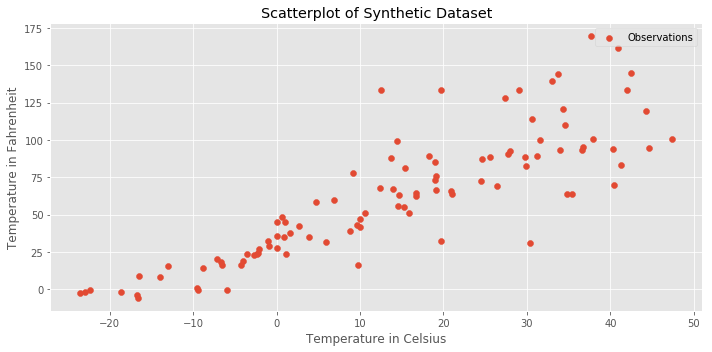

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (10, 5)
plt.style.use('ggplot')

def make_dataset(n_samples=100, noise_level=0.25, seed=3):
    '''
    Function to create a synthetic dataset where y = 32 + 1.8*x
    Create noisy obervations (Gaussian noise) if noise_level > 0
    Returns a 2d numpy array
    '''
    def celsius_to_fahrenheit(C):
        return C*1.8 + 32

    def add_noise(x, noise_level=noise_level):    
        return np.random.normal(x, abs(x*noise_level))
    
    np.random.seed(seed)
    celsius = np.random.randint(-20, 50, n_samples)
    fahrenheit = celsius_to_fahrenheit(celsius)
    observations = add_noise(np.array([celsius, fahrenheit]))
    
    print('Correlation is: {:.2f}'.format(np.corrcoef(observations)[0, 1]))
    return observations

def plot_dataset(data):
    plt.scatter(data[0], data[1], label='Observations')
    plt.title('Scatterplot of Synthetic Dataset')
    plt.xlabel('Temperature in Celsius')
    plt.ylabel('Temperature in Fahrenheit')
    plt.legend()
    plt.tight_layout();

def split_train_test(x, train_size=0.8):
    split_idx = int(x.shape[-1]*train_size)
    return x[:split_idx], x[split_idx:]    


data = make_dataset()
x_train, x_test = split_train_test(data[0])
y_train, y_test = split_train_test(data[1])

plot_dataset(data)

### 2.1 OLS Regression using sci-kit learn

In this part I'm going to use sklearn's `LinearRegression` function to quickly perform Ordinary-Least-Squares (OLS) regression. The model's performance is then evaluated via *Root Mean Squared Error (RMSE)* and $R^2$ for the in-sample and out-of-sample data.  

Since this example has only one explanatory variable, the weights $\mathbf{w}$ are simple the *intercept* and *slope* terms.  

**Note:** For more information about linear regression, including parameter estimation via the Maximum Likelihood method and building it from scratch, you can check out my notebook *Maximum Likelihood Estimation for Linear Regression from Scratch* (Filename: *LinearRegression_Numpy_MLE.ipynb*)

Regression coefficients: 
 intercept = 34.7758 
 slope = 2.0287
R^2: 
 In-sample: 0.7320 
 Out-of-sample: 0.6994
RMSE: 
 In-sample: 22.4046 
 Out-of-sample: 19.6069


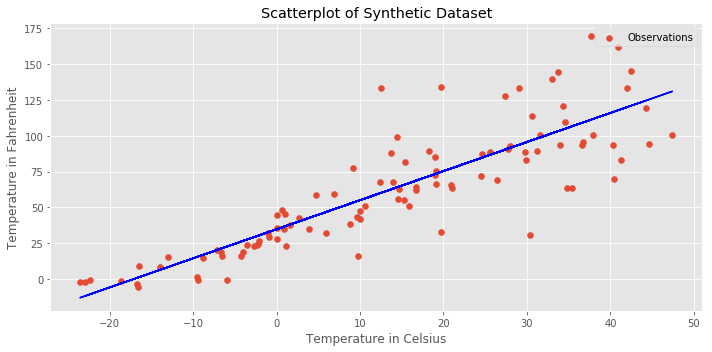

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def rmse(y_true, y_pred):
    return np.sqrt(1/len(y_true) * sum((y_true-y_pred)**2))


# fit the model
ols = LinearRegression()
ols.fit(x_train.reshape(-1, 1), y_train)

# get in-sample and out-of-sample predictions
y_train_hat = ols.predict(x_train.reshape(-1, 1))
y_test_hat = ols.predict(x_test.reshape(-1, 1))
print('Regression coefficients: \n intercept = {:.4f} \n slope = {:.4f}'.format(ols.intercept_,
                                                                                ols.coef_[0]))

# evaluate the performance with R^2 and RSME
print('R^2: \n In-sample: {:.4f} \n Out-of-sample: {:.4f}'.format(r2_score(y_train, y_train_hat),
                                                                  r2_score(y_test, y_test_hat)))
print('RMSE: \n In-sample: {:.4f} \n Out-of-sample: {:.4f}'.format(rmse(y_train, y_train_hat),
                                                                   rmse(y_test, y_test_hat)))

# plot the regression line      
plot_dataset(data)
plt.plot(x_train, y_train_hat, color='b', label='Regression line fit')
plt.tight_layout();

Now let's inspect the residuals $r_i = y_i - \hat y_i$ and plot the predicted vs. the actual values:

Residuals: Mean is 0.0000 and std. deviation is 22.4046


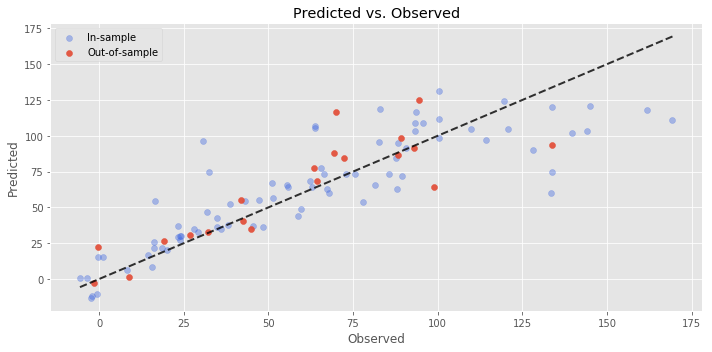

In [177]:
def plot_predictions(y_train, y_train_hat, y_test, y_test_hat):
    plt.scatter(y_train, y_train_hat, color='royalblue', alpha=.4, label='In-sample')
    plt.scatter(y_test, y_test_hat, alpha=.9, label='Out-of-sample')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
             'k--', lw=2, alpha=.8)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    plt.title('Predicted vs. Observed')
    plt.legend()
    plt.tight_layout();
    
    
residuals = y_train-y_train_hat
print('Residuals: Mean is {:.4f} and std. deviation is {:.4f}'.format(residuals.mean(), residuals.std()))

plot_predictions(y_train, y_train_hat, y_test, y_test_hat)

# 3. The Bayesian Approach
Starting again with the likelihood equation $\mathcal{L}(\mathbf y|\mathbf{\mathbf X},\mathbf w)$ from chapter 2, one can apply Bayes' Theorem:

\begin{align} 
p(\mathbf w|\mathcal{D}) = \frac{p(\mathbf y|\mathbf{\mathbf X},\mathbf w) p(\mathbf w)}{p(\mathbf y|\mathbf{\mathbf X})} = \frac{p(\mathbf y|\mathbf{\mathbf X},\mathbf w) p(\mathbf w)}{\int p(\mathbf y|\mathbf{\mathbf X},\mathbf w) p(\mathbf w) \mathrm{d}\mathbf w} \propto p(\mathbf y|\mathbf{\mathbf X},\mathbf w) p(\mathbf w),
\end{align} 

to compute the posterior $p(\mathbf w|\mathcal{D})$, which is required to compute the predictive posterior.  
*Note: For convenience, the above mentioned likelihood function is here denoted with $p(\mathbf y|\mathbf{\mathbf X},\mathbf w)$ instead of $\mathcal{L}(\mathbf y|\mathbf{\mathbf X},\mathbf w)$.*

From Bayes' Theorem, it can be seen that it is required to specify a prior distribution $p(\mathbf w)$ over $\mathbf w$. Assuming a Gaussian prior distribution with zero mean and covariance matrix $\mathbf\Sigma_p$, $\mathbf w \sim \mathcal{N}(\mathbf0, \mathbf\Sigma_p)$, it is possible to obtain a closed form solution for the posterior, since both, the likelihood and the prior are Gaussians, hence, their product is also a Gaussian:

\begin{align} 
p(\mathbf w|\mathcal{D}) &\propto \exp \Big{(} -\frac{1}{2\sigma^2} (\mathbf y - \mathbf X \mathbf w)^T (\mathbf y - \mathbf X \mathbf w) \Big{)} \exp \Big{(}-\frac{1}{2} \mathbf w^T \mathbf\Sigma^{-1}_p \Big{)}\\ \\
&\propto \exp\Big{(} -\frac{1}{2}(\mathbf w-\mathbf\mu_w)^T \mathbf\Sigma^{-1}_w (\mathbf w-\mathbf\mu_w)\Big{)}.
\end{align} 

This leads to $p(\mathbf w|\mathcal{D}) \sim \mathcal{N}(\mathbf\mu_w, \mathbf\Sigma_w)$, with 

\begin{align} 
\mathbf\mu_w &= \sigma^{-2}_n(\sigma^{-2}_n \mathbf{\mathbf X} \mathbf{\mathbf X}^T + \mathbf\Sigma^{-1}_p)^{-1} \mathbf{\mathbf X} \mathbf y \\
\mathbf\Sigma_w &= (\sigma^{-2}_n \mathbf{\mathbf X} \mathbf{\mathbf X}^T + \mathbf\Sigma^{-1}_p)^{-1}.
\end{align} 

From here, it is possible to continue either with:  

1.) Analytical closed-form solution of the posterior, since the prior and the likelihood are Gaussians. For this particular case, the model is effectively equivalent to $l_2 norm$ regularized regression, i.e. *ridge regression* .  
2.) *Maximum-a-Posteriori Estimation* (MAP)  
3.) *full Bayesian inference*.  

I'm going to demonstrate 2.) and 3.) here, more information about regularization from a Bayesian perspective is provided in another notebook.

# 3.1 The Bayesian Approach - Maximum-a-Posteriori Estimation

Altough Maximum-a-Posteriori (MAP) Estimation is consired a Bayesian approach, it provides only a point estimate and is rather related to MLE than to Bayesian inference. The estimator can be derived by

\begin{align} 
\begin{split}
\hat{\mathbf{w}}_{MAP} &= \operatorname*{arg~max}_{\mathbf{w}} p(\mathbf{X}|\mathbf{w})p(\mathbf{w}) \\
&= \operatorname*{arg~max}_{\mathbf{w}} \log p(\mathbf{X}|\mathbf{w})p(\mathbf{w}) \\
&= \operatorname*{arg~max}_{\mathbf{w}} \log \prod\limits_{i}p(\mathbf x_i|\mathbf{w})p(\mathbf{w}) \\
&= \operatorname*{arg~max}_{\mathbf{w}} \sum\limits_{i}\log p(\mathbf x_i|\mathbf{w})p(\mathbf{w})
\end{split}
\end{align} 

Compared with $\hat{\mathbf{w}}_{MLE}$, the only exception is that $\hat{\mathbf{w}}_{MAP}$ considers the prior $p(\mathbf{w})$. If one specifies a uniform distribution $\mathcal{U}$ over the prior, it becomes a constant and hence, $\hat{\mathbf{w}}_{MAP}$ with $p(\mathbf{w}) \sim \mathcal{U}(a, b)$ is equivalent to $\hat{\mathbf{w}}_{MLE}$. The MAP estimate of $\hat{\mathbf{w}}_{MAP}$ is the *mode* of the posterior distribution, which is for symmetric distributions the same as the mean and the median.  

Another interesting property of MAP is that it clarifies the relationship between the likelihood and the prior: Since the likelihood is dependent on the data $\mathbf{\mathbf X}$, while the prior is only dependent on constant parameters $\mathbf{w}$, for an increasing amount of data $N$, the MAP estimate converges torwards the MLE.

# 3.2 The Bayesian Approach - Bayesian Inference

Primarly, it is possible to perform Bayesian Inference either with conjugate priors, i.e. one that comes from the same family of distributions as the likelihood, or with approximating the posterior. The approximation is required because we can't simply compute the *evidence*  $p(\mathcal{D})$ from Bayes' theorem, since it requires integrating over the entire dataset:

\begin{align} 
p(\mathcal{D}) = \int{p(\mathcal{D}|\mathbf\theta) p(\mathbf\theta)} \: \text{d}\mathbf\theta \: ,
\end{align}

which is often high-dimensional and intractable. The two common approaches to handle this are (1.) *Markov Chain Monte Carlo* (MCMC) methods or (2.) *Variationial Inference* (VI). While MCMC typically leads to more exact and therefore better approximations than VI, it is computationally much more expensive. Detailed information about MCMC and VI is presented in the 3rd part of this series - check out the notebook *Introduction to Bayesian Inference (3)* (Filename: *BayesianInference3.ipynb*). The rationale behind these methods is roughly said:  
* MCMC: Approximate the posterior by exploring the probabilty space with random sampling
* VI: Approximate the posterior by constructing a similiar distribution that is easy to parametrize.  

In this notebook I'm going to introduce probabilistic programming by using the *No-U-Turn Sampler* (NUTS), a sophisticated MCMC method. Details about NUTS are available at https://arxiv.org/abs/1111.4246 .

# 4. Probabilistic Programming

To choose a conjugate prior is not always easy nor does it need to be a feasible option. Moreover, defining priors and the likelihood can be exhausting with pure python/scipy. Luckily, there is a much better way to practically use Bayesian inference methods: *Probabilistic Programming*. This allows to specify a model as a program, defining priors easily and perform inference via different techniques. Popular libraries for python are e.g.:

* PyMC3
* Edward2 (included in TensorFlow Probability)
* PyStan
* Pyro  

In this example I'm going to use PyMC3, which has a lot of great features and an excellent documentation. On the downside, it's build on top of thenao, a discontinued deep learning library. However, you don't acutually need knowledge  of theano. You can find out more about PyMC3 at https://docs.pymc.io/ , including many examples.     
<br>

## 4.1 OLS Regression Model using PyMC3
The first aspect to know is that you don't use PyMC3 (or any other probabilistic programming framework) if you are not using a probabilistic model. I've implemented the same model as above with sci-kit learn here, but only to show the synthax of PyMC3.

A model is always specified with the `with` statement. According to the above made assumptions, the data is assumed to be normally distributed and hence, the likelihood function is the normal distribution with $\mathbf y \sim \mathcal{N}(\mathbf{X}\mathbf w, \sigma^2 \mathbf{I}) \: ,$ where the weights $\mathbf{w}$ are the *intercept* and *slope*.  

Even if we are actually not going to use priors here, it is required to either define a variable as stochastic, using one of the many included probability distributions, or as a determinstic variable with a fixed value. Therefore, a uniform prior is placed on the *intercept* and *slope* with `pm.flat`, which is equivalent to setting no prior at all. The $\sigma$ term is the *error*, wrapped in a theano tensor with `theano.shared(variable)`.  

As mentioned above, for the assumption of normally distributed data the OLS and MLE are equivalent for a regression model.  Since one can not use MLE for probabilistic programming, the MAP estimate is equivalent to the MLE for uniform priors. In PyMC3 the MAP estimation is performed with `pm.find_map`, which uses the *Broyden–Fletcher–Goldfarb–Shanno* (BFGS) algorithm (second order optimization) by default.

In [56]:
import pymc3 as pm
import theano

with pm.Model() as model:
    # define priors
    sigma = pm.Deterministic('sigma', var=theano.shared(y_train.std()))
    intercept = pm.Flat('intercept')
    slope = pm.Flat('slope')
    
    # define likelihood
    likelihood = pm.Normal('y', mu=intercept + slope * x_train,
                           sd=sigma, observed=y_train)

# inference
y_hat = pm.find_MAP(model=model)

print('Regression coefficients: \n intercept = {:.4f} \n slope = {:.4f}'.format(y_hat['intercept'],
                                                                                y_hat['slope']))

c:\programdata\anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -385.65, ||grad|| = 8.3336e-05: 100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 1448.81it/s]


Regression coefficients: 
 intercept = 34.7758 
 slope = 2.0287


As we can see, the results are identical to OLS regression.
<br>

## 4.2 Bayesian Linear Regression using PyMC3

Cleary, this approach is unnecessary complicated, so let's use PyMC3 for what it's made for - full Bayesian Inference. I'm using the same model and data as above, but this time with informative priors and MCMC sampling to approximate the posterior.  

<u> **Scenario:** </u>  
*Imagine someone suggested that our thermometers might be in Fahrenheit, so the true values would be 1.8 for the slope and 32 for the intercept.*  

My elected priors are therefore:

* $sigma ∼ HalfNormal(sd=22.0) \: ,$  since the standard deviation can't be negative and from the OLS model we saw that the error is $\approx 22$
* $intercept∼Normal(mu=32, sd=1.0) \: ,$  reflects a strong prior knowledge that it should be around 32
* $slope∼Normal(mu=1.8, sd=0.1) \: ,$  reflects a strong prior knowledge that it should be around 1.8

In [160]:
def bayes_reg(x_shared, y_shared):
    with pm.Model() as model:
        # define priors
        sigma = pm.HalfNormal('sigma', sd=22)
        intercept = pm.Normal('intercept', 32, sd=1)
        slope = pm.Normal('slope', 1.8, sd=.1)

        # define likelihood
        likelihood = pm.Normal('y', mu=intercept + slope * x_shared,
                               sd=sigma, observed=y_shared)
    
    return model


x_shared = theano.shared(x_train)
y_shared = theano.shared(y_train)

model = bayes_reg(x_shared, y_shared)

# inference (NUTS)
with model:
    trace = pm.sample(3000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [slope, intercept, sigma]
Sampling 2 chains: 100%|██████████████████████████████████████████████████████| 7000/7000 [00:05<00:00, 1258.40draws/s]


Now that we used MCMC sampling, the results are stored in the `trace` object, from which we can get the traceplot and some summary statistics. The traceplot shows the estimated distributions of the parameters on the left side and the samples from the MCMC chains on the right side. The chains seem to be converged, i.e. stationary around a constant mean.  I'm providing more information about the traceplot in the next part of the series.  

From the summary we can see that the means of the parameters are now notably closer to the true values. 

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
intercept,32.548132,0.938298,0.010025,30.775395,34.447948,7696.873478,0.999939
slope,1.928966,0.075652,0.000885,1.788346,2.086718,8147.598154,0.999897
sigma,23.036080,1.847700,0.024143,19.565925,26.671313,6169.262038,0.999850


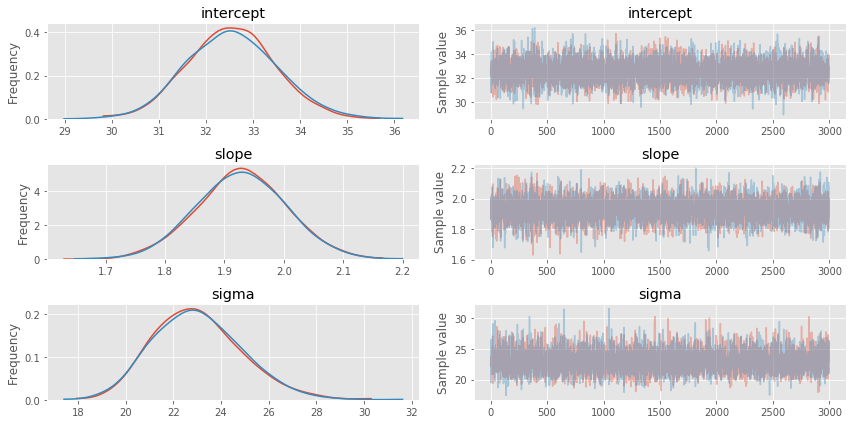

In [161]:
pm.traceplot(trace, grid=True);
pm.summary(trace)

Here is the summary if we would choose the same prior distributions, but with more diffuse priors (for all variables, the slope, intercept and sigma with: $mean = 0$ and $std. dev = 20$). The results are closer to the OLS model. (Note: I continue to use the above fitted model with informative priors - this one is just to demonstrate the differences.)

In [58]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
intercept,33.910518,3.189170,0.049416,27.694717,39.941072,3493.677743,1.000875
slope,2.051182,0.139535,0.002166,1.773760,2.324276,3611.265437,1.000559
sigma,22.876194,1.834311,0.027070,19.179487,26.419316,5065.367366,0.999841


Let's plot some ($n=20$) from the above created samples against the OLS results and the observed data to get a better understanding about the variation of the parameters:

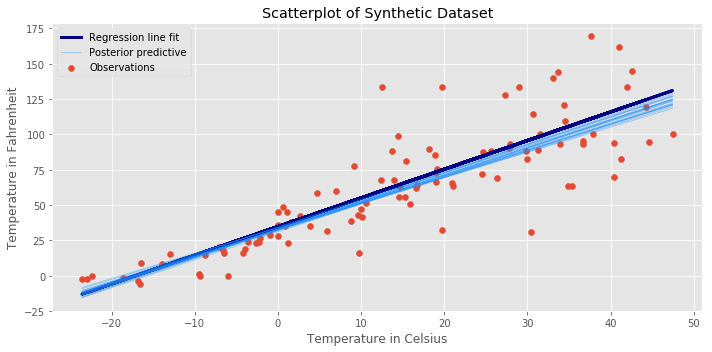

In [61]:
from collections import OrderedDict

def plot_posterior_predictive(trace, x_axis_min, x_axis_max, n_samples=20, burnin=1000,
                              label_alpha='intercept',
                              label_beta='slope'):
    alpha = trace.get_values(label_alpha, burn=burnin)
    beta = trace.get_values(label_beta, burn=burnin)
    
    def pred_reg(x, alpha, beta):
        return alpha + x*beta

    x_vals = np.linspace(x_axis_min, x_axis_max, 100)
    
    for idx in np.random.randint(0, len(alpha), n_samples):       
        plt.plot(x_vals, pred_reg(x_vals, alpha[idx], beta[idx]), alpha=.5, 
                 color='dodgerblue', linewidth=.7, label='Posterior predictive')
    
    # avoid plotting labels multiple times
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.tight_layout();
    
    
plot_dataset(data)
plt.plot(x_train, y_train_hat, color='navy', linewidth=3, label='Regression line fit')
plot_posterior_predictive(trace, x_train.min(), x_train.max())

The results are quite narrow, i.e. our model is pretty confident about the parameters distribution, which is not suprising for such a easy problem. But since we are now dealing with probability distributions instead of simple point estimates, we can explore the model's uncertainty about the parameters.  

This information is certainly useful, but many machine-learning tasks involve building predictive models. For the frequentist model we are simply using the regression coefficients and multiply them with the explanatory variable(s). I.e. we would like to have something like sklearn's `model.predict()` function.  

To get predictions from a Bayesian model, it is required to obtain the *posterior predictive distribution* for a new datapoints $\mathbf{y^*}$, given new explanatory variable(s) $\mathbf{X^*}$. This can be formally expressed by:

\begin{align}
p(\mathbf{y^*}| \mathbf{X^*} , \mathbf{X}, \mathbf{y}) \: .
\end{align}

For simplification, the conditioned variables $\mathbf{X^*}$ and $\mathbf{X}$ are omitted from the statement such that $p(\mathbf{y^*}| \mathbf{y})$ can be written as:

\begin{align}
p(\mathbf{y^*}| \mathbf{y}) = \int p(\mathbf{y^*}| \mathbf{w}) \: p(\mathbf{w}|\mathbf{y}) \: \text{d}\mathbf{w}  \: .
\end{align}

Further, we can denote our priors for the weights as $\mathbf{\alpha}$ and for the error as $\beta$, such that we can now write the posterior predictive as:

\begin{align}
p(\mathbf{y^*}| \mathbf{y}, \mathbf{\alpha}, \beta) = \int p(\mathbf{y^*}| \mathbf{w}, \beta) \: p(\mathbf{w}|\mathbf{y}, \mathbf{\alpha}, \beta) \: \text{d} \mathbf{w}  \: .
\end{align}

If you are interested in the mathematical background of this I would recommend reading *Bishop - Chapter 3* or *Rogers &  Girolami - Chapter 3* (see references below).  

To get predictions with the posterior predictive in PyMC3 we can use the `pm.sample_posterior_predictive` function, which allows sampling from it:

In [162]:
with model:
    ppc_train = pm.sample_posterior_predictive(trace, samples=500)

ppc['y'].shape

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 100.58it/s]


(500, 80)

From that we see that we now got 500 samples for each in-sample datapoint from the posterior predictive. We can now inspect the means and std. deviations from that:

In [163]:
train_sample_means = ppc_train['y'].mean(axis=0)
train_sample_stds = ppc_train['y'].std(axis=0)

To get out-of-sample predictions, it is required to change the input variables. You may noticed that I wrapped the y_train and y_test variables into `theano.shared()` objects before fitting the model above. This step allows to change the inputs and get predictions from the posterior predictive on hold-out data. Here we need to change the theano variables at first and then call our model again, but without perform inferencing.

In [165]:
x_shared.set_value(x_test)
y_shared.set_value(y_test)

model = bayes_reg(x_shared, y_shared)

with model:
    ppc_test = pm.sample_posterior_predictive(trace, samples=500)
    
test_sample_means = ppc_test['y'].mean(axis=0)
test_sample_stds = ppc_test['y'].std(axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 99.75it/s]


Now we can evaluate our results by looking at the $R^2$ and RSME scores and plot the predictions vs. the observed variables.

R^2: 
 In-sample: 0.7239 
 Out-of-sample: 0.7206
RMSE: 
 In-sample: 22.7423 
 Out-of-sample: 18.9001


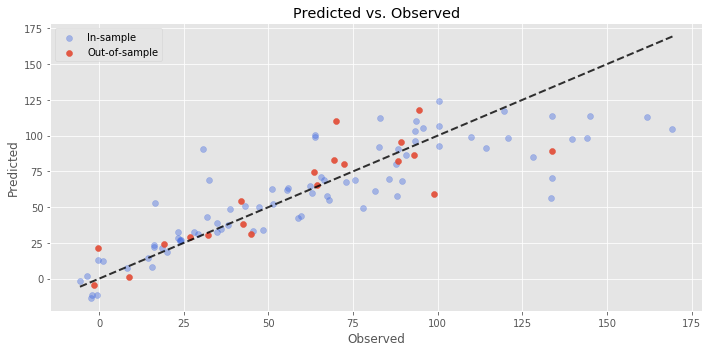

In [168]:
# evaluate the performance with R^2 and RSME
print('R^2: \n In-sample: {:.4f} \n Out-of-sample: {:.4f}'.format(r2_score(y_train, train_sample_means),
                                                                  r2_score(y_test, test_sample_means)))
print('RMSE: \n In-sample: {:.4f} \n Out-of-sample: {:.4f}'.format(rmse(y_train, train_sample_means),
                                                                   rmse(y_test, test_sample_means)))

plot_predictions(y_train, train_sample_means, y_test, test_sample_means)

Compared to the OLS model we have improved our results slightly. However, we also got information about the included uncertainty in form of the entire distribution. We could now e.g. use the above calculated std. deviation to quantify that uncertainty as a single variable.

In [174]:
print('Average std. deviation \n In-sample: {:.4f} \n Out-of-Sample: {:.4f}'.format(test_sample_stds.mean(),
                                                                                   train_sample_stds.mean()))

Average std. deviation 
 In-sample: 23.0070 
 Out-of-Sample: 23.1974


Clearly, this is a bit overpowered for such a simple example, but it can be very helpful for complex models, where one can not simply evaluate the contained uncertainty with frequentist methods.

# Resume
* Bayesian regression methods can be used to get information about the models' uncertainty
* By including informative priors it is possible to incorporate expert knowledge / personal beliefs
* Probabilistic programming allows for highly flexible models
* Bayesian statistics is essentially a different perspective and rather not a different set of methods

In [176]:
% load_ext watermark
% watermark -d -v -iv -p sklearn

matplotlib 2.2.2
pymc3      3.6
theano     1.0.3
numpy      1.16.2
2019-05-07 

CPython 3.6.4
IPython 6.2.1

sklearn 0.20.2


# References
**Note:** Parts from this notebook are from my thesis - *A Bayesian Approach to Machine Learning for Algorithmic Trading* (2019).  

[1] Barber, D. (2012). Bayesian reasoning and machine learning. Cambridge University Press.  
[2] Bishop, C. M. (2006). Pattern recognition and machine learning (information science and statistics). Berlin, Heidelberg: Springer-Verlag.  
[3] Gelman, A., et al. (2013). Bayesian Data Analysis (2nd ed.). Chapman & Hall/CRC.  
[4] Murphy, K. P. (2013). Machine learning : a probabilistic perspective. Cambridge, Mass. [u.a.]: MIT Press.  
[5] Rogers, S. & Girolami, M. (2017). A First Course in Machine Learning. Chapman & Hall/CRC.  
[6] Theodoridis, S. (2015). Machine learning: A bayesian and optimization perspective (1st ed.). Orlando, FL, USA: Academic Press, Inc.  